In [10]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Install dependencies (if not already installed)
!pip install nltk rouge-score transformers --quiet

import nltk
nltk.download('wordnet')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

from transformers import ViTModel, AutoTokenizer, pipeline, GPT2Model
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

[nltk_data] Downloading package wordnet to /home/rohit-am/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
'''
This cell defines a custom PyTorch dataset class CustomImageCaptionDataset for loading images and their corresponding captions from a CSV file. 
It supports optional image transformations and tokenizes captions using a provided tokenizer, making it suitable for image captioning tasks.
'''
class CustomImageCaptionDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform=None, tokenizer=None, max_length=30):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        if 'filename' not in self.df.columns or 'caption' not in self.df.columns:
            raise ValueError("CSV must have 'filename' and 'caption' columns.")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        caption = row['caption']
        image_path = os.path.join(self.images_folder, filename)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            tokens = self.tokenizer.encode(caption, truncation=True, max_length=self.max_length, padding='max_length')
            tokens = torch.tensor(tokens)
        else:
            tokens = caption
        
        return image, tokens, caption


In [ ]:
'''
This cell performs generates caption using SMOLvlm model using code given in tutorial 
'''

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def zero_shot_captioning(image_path: str,
                         model_name: str = "HuggingFaceTB/SmolVLM-256M-Instruct",
                         token: str = None) -> str:
    processor = AutoProcessor.from_pretrained(model_name, token=token)
    model = AutoModelForVision2Seq.from_pretrained(model_name,torch_dtype=torch.bfloat16,_attn_implementation="eager",token=token).to(DEVICE)
    image = Image.open(image_path).convert("RGB")

    # Define the prompt using the chat template
    messages = [
        {"role": "user",
         "content": [
              {"type": "image"},
              {"type": "text", "text": "Describe this image."}
             ]
        }
    ]
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to(DEVICE)

    # Generate caption
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    generated_ids = generated_ids[:, inputs['input_ids'].shape[1]:]
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return caption

In [ ]:
'''
The ImageCaptionModel is a vision-to-text model that uses:
ViT (encoder) to process images
GPT-2 (decoder) to generate captions
A projection layer to align ViT's output with GPT-2's input
Concatenates image features with text embeddings for conditional caption generation

Output: Next-token prediction logits for captions.
'''


class ImageCaptionModel(nn.Module):
    def __init__(self, 
                 encoder_model_name="google/vit-base-patch16-224", 
                 decoder_model_name="gpt2",                   
                 max_seq_length=50):
        super(ImageCaptionModel, self).__init__()
        self.encoder = ViTModel.from_pretrained(encoder_model_name)
        encoder_hidden_dim = self.encoder.config.hidden_size  
        self.decoder = GPT2Model.from_pretrained(decoder_model_name)
        decoder_embed_dim = self.decoder.config.n_embd  
        self.encoder_proj = nn.Linear(encoder_hidden_dim, decoder_embed_dim)
        self.vocab_size = self.decoder.config.vocab_size  
        self.fc_out = nn.Linear(decoder_embed_dim, self.vocab_size)
        
        self.max_seq_length = max_seq_length

    def forward(self, images, captions):
        batch_size = images.size(0)
        encoder_outputs = self.encoder(images).last_hidden_state
        memory = self.encoder_proj(encoder_outputs)  
        num_image_tokens = memory.size(1)  
        caption_embeddings = self.decoder.wte(captions) 
        inputs_embeds = torch.cat([memory, caption_embeddings], dim=1)
        seq_length = captions.size(1)
        position_ids = torch.arange(0, num_image_tokens + seq_length, dtype=torch.long, device=captions.device).unsqueeze(0).repeat(batch_size, 1)
        decoder_outputs = self.decoder(inputs_embeds=inputs_embeds, position_ids=position_ids).last_hidden_state  
        caption_outputs = decoder_outputs[:, num_image_tokens:, :]  
        logits = self.fc_out(caption_outputs)  
        
        return logits

In [ ]:
'''
This code trains the `ImageCaptionModel` for image captioning. 
It processes batches of images and captions, using **teacher forcing** (feeding correct previous tokens during training) to predict the next word in captions. 
The cross-entropy loss is computed and backpropagated to update model weights. Training progress is logged with batch/epoch losses, and model weights are saved after each epoch. 
The entire model (ViT encoder + GPT-2 decoder) is optimized end-to-end on the specified device (CPU/GPU).
'''
def train_model(model, dataloader, optimizer, criterion, device, epochs, save_path="model_weights.pt"):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        batch_count = 0
        print(f"\nStarting Epoch [{epoch+1}/{epochs}]")
        for images, captions, _ in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            # Teacher forcing: input is captions[:, :-1], target is captions[:, 1:]
            input_captions = captions[:, :-1]
            target_captions = captions[:, 1:]
            
            optimizer.zero_grad()
            outputs = model(images, input_captions)
            outputs = outputs.reshape(-1, outputs.size(-1))
            target_captions = target_captions.reshape(-1)
            
            loss = criterion(outputs, target_captions)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_count}/{len(dataloader)}] Loss: {loss.item():.4f}")
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] completed. Average Loss: {avg_loss:.4f}\n")
        
        # Save model weights after each epoch
        torch.save(model.state_dict(), save_path)
        print(f"Model weights saved to {save_path}")

In [ ]:
'''
This code runs the test and validation set on model trained 
'''
def evaluate_model(model, dataloader, device, tokenizer):
    model.to(device)
    model.eval()
    
    bleu_scores = []
    meteor_scores_ = []
    rouge_l_scores = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    batch_count = 0
    with torch.no_grad():
        for images, captions, raw_captions in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            batch_size = images.size(0)
            start_token = tokenizer.eos_token_id
            generated = torch.full((batch_size, 1), start_token, dtype=torch.long).to(device)
            for _ in range(model.max_seq_length - 1):
                outputs = model(images, generated)
                next_token = outputs[:, -1, :].argmax(dim=-1, keepdim=True)
                generated = torch.cat([generated, next_token], dim=1)
            
            for i in range(batch_size):
                pred_caption = tokenizer.decode(generated[i], skip_special_tokens=True)
                ref_caption = raw_captions[i]
                smooth = SmoothingFunction().method1
                bleu = sentence_bleu([ref_caption.split()], pred_caption.split(), smoothing_function=smooth)
                bleu_scores.append(bleu)
                m_score = meteor_score([ref_caption.split()], pred_caption.split())
                meteor_scores_.append(m_score)
                r_score = scorer.score(ref_caption, pred_caption)['rougeL'].fmeasure
                rouge_l_scores.append(r_score)
            
            batch_count += 1
            print(f"Processed batch {batch_count}/{len(dataloader)}")
    
    results = {
        "BLEU": np.mean(bleu_scores),
        "METEOR": np.mean(meteor_scores_),
        "ROUGE-L": np.mean(rouge_l_scores)
    }
    return results

In [ ]:
'''
This code runs the test and validation set on SMOLvlm 
'''
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_zero_shot(test_dataset, model_name: str = "HuggingFaceTB/SmolVLM-256M-Instruct", token: str = None) -> dict:
    bleu_scores = []
    meteor_scores = []
    rouge_l_scores = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    print(f"Loading zero-shot SmolVLM model: {model_name} with attn_implementation='eager' ...")
    processor = AutoProcessor.from_pretrained(model_name, token=token)
    model = AutoModelForVision2Seq.from_pretrained(model_name,torch_dtype=torch.bfloat16,_attn_implementation="eager",token=token).to(DEVICE)
    print("Model loaded.\n")
    dataset_root = "custom_captions_dataset"
    test_folder = os.path.join(dataset_root, "test")
    for idx in range(len(test_dataset)):
        # Get filename from dataset's underlying dataframe and build full image path
        filename = test_dataset.df.iloc[idx]['filename']
        image_path = os.path.join(test_folder, filename)
        ref_caption = test_dataset.df.iloc[idx]['caption']
        generated_caption = zero_shot_captioning(image_path, model_name=model_name, token=token)
        
        # Compute metrics (tokenized by whitespace)
        smooth = SmoothingFunction().method1
        bleu = sentence_bleu([ref_caption.split()], generated_caption.split(), smoothing_function=smooth)
        meteor = meteor_score([ref_caption.split()], generated_caption.split())  
        rouge_l = scorer.score(ref_caption, generated_caption)['rougeL'].fmeasure
        
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        rouge_l_scores.append(rouge_l)
        
        print(f"[{idx+1}/{len(test_dataset)}] BLEU: {bleu:.4f}, METEOR: {meteor:.4f}, ROUGE-L: {rouge_l:.4f}")
    
    results = {
        "BLEU": np.mean(bleu_scores),
        "METEOR": np.mean(meteor_scores),
        "ROUGE-L": np.mean(rouge_l_scores)
    }
    print("\nZero-shot evaluation complete.")
    print(f"Average Scores -> BLEU: {results['BLEU']:.4f}, METEOR: {results['METEOR']:.4f}, ROUGE-L: {results['ROUGE-L']:.4f}")
    return results

In [ ]:
'''
main function where all functions are called 
'''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Define dataset paths (adjust if necessary)
dataset_root = "custom_captions_dataset"
train_csv = os.path.join(dataset_root, "train.csv")
val_csv = os.path.join(dataset_root, "val.csv")
test_csv = os.path.join(dataset_root, "test.csv")
train_folder = os.path.join(dataset_root, "train")
val_folder = os.path.join(dataset_root, "val")
test_folder = os.path.join(dataset_root, "test")

# Define transforms (must match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Initialize tokenizer (using GPT-2 tokenizer)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # set pad token

# Create datasets
train_dataset = CustomImageCaptionDataset(csv_path=train_csv, images_folder=train_folder,
                                            transform=transform, tokenizer=tokenizer, max_length=30)
val_dataset = CustomImageCaptionDataset(csv_path=val_csv, images_folder=val_folder,
                                          transform=transform, tokenizer=tokenizer, max_length=30)
test_dataset = CustomImageCaptionDataset(csv_path=test_csv, images_folder=test_folder,
                                           transform=transform, tokenizer=tokenizer, max_length=30)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = ImageCaptionModel()
model.to(device)

# Define optimizer and loss criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Path to save/load model weights
weights_path = "model_weights.pt"

# Check if saved weights exist
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Loaded model weights from {weights_path}")
else:
    print("No saved weights found. Training from scratch.")
    
# # Train on training set (even if you loaded existing weights, you may want to fine-tune further)
# print("\n=== Training Custom Model ===")
# train_model(model, train_loader, optimizer, criterion, device, epochs=5, save_path=weights_path)

Using device: cuda


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model weights from model_weights.pt


In [18]:
# Evaluate on validation set (optional)
val_metrics = evaluate_model(model, val_loader, device, tokenizer)
print("\nValidation Metrics (Custom Model):", val_metrics)

# Evaluate on test set using custom model
test_metrics_custom = evaluate_model(model, test_loader, device, tokenizer)
print("\nTest Metrics (Custom Model):", test_metrics_custom)

Processed batch 1/60
Processed batch 2/60
Processed batch 3/60
Processed batch 4/60
Processed batch 5/60
Processed batch 6/60
Processed batch 7/60
Processed batch 8/60
Processed batch 9/60
Processed batch 10/60
Processed batch 11/60
Processed batch 12/60
Processed batch 13/60
Processed batch 14/60
Processed batch 15/60
Processed batch 16/60
Processed batch 17/60
Processed batch 18/60
Processed batch 19/60
Processed batch 20/60
Processed batch 21/60
Processed batch 22/60
Processed batch 23/60
Processed batch 24/60
Processed batch 25/60
Processed batch 26/60
Processed batch 27/60
Processed batch 28/60
Processed batch 29/60
Processed batch 30/60
Processed batch 31/60
Processed batch 32/60
Processed batch 33/60
Processed batch 34/60
Processed batch 35/60
Processed batch 36/60
Processed batch 37/60
Processed batch 38/60
Processed batch 39/60
Processed batch 40/60
Processed batch 41/60
Processed batch 42/60
Processed batch 43/60
Processed batch 44/60
Processed batch 45/60
Processed batch 46/

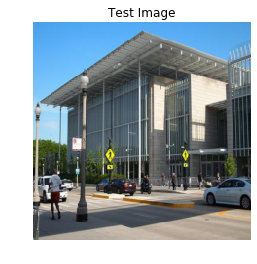

Ground Truth: A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it. 
Custom Model:  The sky is partly cloudy but still blew. There is a glass building on the right with a clock on the left. The sky is blue in the white building. There are several people walking on the platform. There are people walking towards the roof
---------------------------------------------------


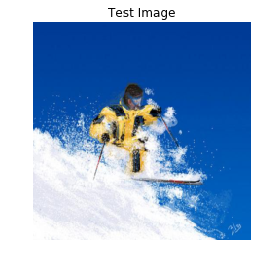

Ground Truth: A person is skiing through the snow. There is loose snow all around them from him jumping. The person is wearing a yellow snow suit. The person is holding two ski poles in their hands. 
Custom Model:  a man is snowboarding down a hill. the man has a bright pink jacket on. the pants of the man are black in color. he has a bright black ski cap on. the sky is bright blue in the background. the board is
---------------------------------------------------


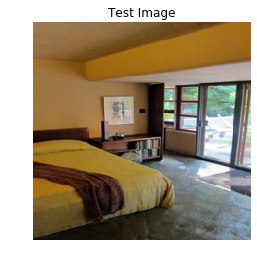

Ground Truth: There is a bed in a room against a wall. There is a brown blanket on top of the bed. There is a small brown book shelf next to the bed. There is a picture hanging on the wall above the shelf. 
Custom Model:  A bedroom has a large bed in the middle of it. The bed has a white blanket on it. There is a lamp next to the bed. There are many pillows on the bed.  A white sink is next to the bed.
---------------------------------------------------


In [19]:
sample_indices = [0,1,2]
for idx in sample_indices:
    image, _, ref_caption = test_dataset[idx]
    # Convert tensor to PIL image for display
    image_disp = transforms.ToPILImage()( (image * 0.5) + 0.5 )
    # Custom model caption generation (greedy decoding)
    image_tensor = image.unsqueeze(0).to(device)
    start_token = tokenizer.eos_token_id
    generated_custom = torch.full((1, 1), start_token, dtype=torch.long).to(device)
    for _ in range(model.max_seq_length - 1):
        outputs = model(image_tensor, generated_custom)
        next_token = outputs[:, -1, :].argmax(dim=-1, keepdim=True)
        generated_custom = torch.cat([generated_custom, next_token], dim=1)
    custom_caption = tokenizer.decode(generated_custom[0], skip_special_tokens=True)
    # Display image and print captions
    plt.figure(figsize=(6,4))
    plt.imshow(image_disp)
    plt.axis("off")
    plt.title("Test Image")
    plt.show()

    print(f"Ground Truth: {ref_caption}")
    print(f"Custom Model: {custom_caption}")
    print("---------------------------------------------------")

In [ ]:
'''
This cell is not run again as its output is shown in Part-B code 
'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define dataset paths (adjust if necessary)
dataset_root = "custom_captions_dataset"
train_csv = os.path.join(dataset_root, "train.csv")
val_csv = os.path.join(dataset_root, "val.csv")
test_csv = os.path.join(dataset_root, "test.csv")
train_folder = os.path.join(dataset_root, "train")
val_folder = os.path.join(dataset_root, "val")
test_folder = os.path.join(dataset_root, "test")

# Define transforms (must match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Initialize tokenizer (using GPT-2 tokenizer)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # set pad token

# Create datasets
train_dataset = CustomImageCaptionDataset(csv_path=train_csv, images_folder=train_folder,
                                            transform=transform, tokenizer=tokenizer, max_length=30)
val_dataset = CustomImageCaptionDataset(csv_path=val_csv, images_folder=val_folder,
                                          transform=transform, tokenizer=tokenizer, max_length=30)
test_dataset = CustomImageCaptionDataset(csv_path=test_csv, images_folder=test_folder,
                                           transform=transform, tokenizer=tokenizer, max_length=30)
# Evaluate on test set using zero-shot SmolVLM
test_metrics_zero_shot = evaluate_zero_shot(test_dataset, model_name="HuggingFaceTB/SmolVLM-256M-Instruct")
print("\nTest Metrics (Zero-shot SmolVLM):", test_metrics_zero_shot)